### ISPR Midterm 3 Assignment 6 
<font size="4"> Paolo Fasano </font> <font size="2"> p.fasano1@studenti.unipi.it</font>


--- 

#### Section 1: The Code

The code in this notebook is divided based on it's purpose:

- 1.1 Loading the Dataset
- 1.2 Preprocessing the Dataset
- 1.3 Training the LSTM model
- 1.4 Taking care of the Dataset unbalance   
- 1.5 Experimenting with bidirectional LSTM 

##### 1.1 Loading the dataset

In [6]:
import pandas as pd
import random

In [7]:
trueNews = pd.read_csv("./dataset/True.csv")
fakeNews = pd.read_csv("./dataset/Fake.csv")

Due to the fact that the dataset do not contains the labels we will add them to the Dataframe variable adding a column label, with "0" if it is a real news or "1" otherwise.  
Another change in the dataset that was deemed useful, was the deletion of the date column to have less information to process, it has been delated because the date has been deemed useless information to identify fake news.

In [8]:
trueNews['label'] = 0
fakeNews['label'] = 1
del trueNews["date"] 
del fakeNews["date"]

In [9]:
def reduceDataset(dataset, precentageReduction = 30, randomDrop = True):
    if precentageReduction == 100:
        reducedDS = pd.DataFrame()    
        return reducedDS
    if precentageReduction == 0.:
        reducedDS = dataset   
        return reducedDS

    reducedDS = dataset
    rowDropList = []
    if randomDrop:
        rowDropList = []
        rowDropList = random.sample(range(0, len(reducedDS)), int((precentageReduction*len(reducedDS))/100))       
        
    else:
        for i in range (0,int((precentageReduction*len(reducedDS))/100)):
            rowDropList.append(i)

    reducedDS = reducedDS.drop(rowDropList)


    return reducedDS


Considering the fact that "in the real world, real news are much more frequent than fake ones", the fake news dataset has been reduced to 60% of it's original length. 

In [10]:
percentReduction = 40
reduceFakeNews = reduceDataset(fakeNews, precentageReduction=percentReduction)
print("the number of fake news before reduction is: ",len(fakeNews))
print("the number of the fake news after ", percentReduction ,"% reduction is: ",len(reduceFakeNews),"\n")
print("the number of real news is: ",len(trueNews)," the number of fake news will be: ",len(reduceFakeNews))

#to create a dataset containing all the "kind" of news the two csv have been concatenated
allNews = pd.concat([reduceFakeNews, trueNews])
print("the full dataset size will be: ", len(allNews))

the number of fake news before reduction is:  23481
the number of the fake news after  40 % reduction is:  14089 

the number of real news is:  21417  the number of fake news will be:  14089
the full dataset size will be:  35506


##### 1.2 Preprocessing the Dataset

In [11]:
#nltk preprocessing library will be used to create a format of data that can be feed to the LSTM
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

The operation that are executed over the dataset to transform it into a useful format are the following:

- Tokenization
- Lemmitization 
- Stop Words removal
- Title and text concatenation: the title and text for each entity in the dataset get concatenated to create a column in the dataset that contains both.

In [12]:
allNews["text"].apply(word_tokenize)
allNews["title"].apply(word_tokenize)

0        [Donald, Trump, Sends, Out, Embarrassing, New,...
1        [Drunk, Bragging, Trump, Staffer, Started, Rus...
3        [Trump, Is, So, Obsessed, He, Even, Has, Obama...
5        [Racist, Alabama, Cops, Brutalize, Black, Boy,...
6        [Fresh, Off, The, Golf, Course, ,, Trump, Lash...
                               ...                        
21412    ['Fully, committed, ', NATO, backs, new, U.S.,...
21413    [LexisNexis, withdrew, two, products, from, Ch...
21414    [Minsk, cultural, hub, becomes, haven, from, a...
21415    [Vatican, upbeat, on, possibility, of, Pope, F...
21416    [Indonesia, to, buy, $, 1.14, billion, worth, ...
Name: title, Length: 35506, dtype: object

In [13]:
lemmatizer = WordNetLemmatizer()
#Loop through title dataframe and lemmatize each word
def lemma(allNews):
    return "".join([lemmatizer.lemmatize(w) for w in allNews])

#Apply to dataframe
allNews['title'] = allNews['title'].apply(lemma)
allNews['text'] = allNews['text'].apply(lemma)

In [14]:
allNews['title_text'] = (allNews["title"]+" "+allNews["text"])
stops = set(stopwords.words('english'))
allNews['title_text'] = allNews['title_text'].apply(lambda text: " ".join([word for word in text.split() if word not in stops]))


##### 1.3 Training the LSTM model

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dropout, Dense 
from keras import Sequential
import tensorflow as tf
from tensorflow import one_hot, pad
import numpy as np
import tensorflow_hub as hub

The next step was to embed the whole text inside allNews['title_text'] to convert each series of words to a word2vec embedding and than pad the sequence with zeros to be sure that all the sections have the same length, this is done to account for different length of words 

In [16]:

embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

emb_news_train = []
for i in allNews['title_text']:
  temp = np.array(embed([i]))
  emb_news_train.append(temp)

emb_title = tf.keras.preprocessing.sequence.pad_sequences(emb_news_train,dtype='float')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(emb_title, allNews["label"].values, test_size=0.3, random_state=42)

print(X_train.shape)
 
testSet_text= X_train[:5000]
testSet_label=y_train[:5000]

X_train = X_train[5000:]
y_train = y_train[5000:]
 

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(24854, 1, 250)
(19854, 1, 250)
(10652, 1, 250)
(19854,)
(10652,)


The next step was to create and train the model for the classification, the layers used were:
- LSTM layer: to analyze the sequence of data;
- Dropout layer: to avoid overfitting;
- Dense layer: as output layer with a sigmoid function;

In [79]:

model= Sequential()
model.add(LSTM(90)) 
model.add(Dropout(0.3)) 
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/15
311/311 [==============================] - 3s 5ms/step - loss: 0.2571 - accuracy: 0.9049 - val_loss: 0.1579 - val_accuracy: 0.9485
Epoch 2/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1465 - accuracy: 0.9494 - val_loss: 0.1431 - val_accuracy: 0.9509
Epoch 3/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1295 - accuracy: 0.9558 - val_loss: 0.1153 - val_accuracy: 0.9599
Epoch 4/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1168 - accuracy: 0.9600 - val_loss: 0.1230 - val_accuracy: 0.9576
Epoch 5/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1129 - accuracy: 0.9598 - val_loss: 0.1056 - val_accuracy: 0.9634
Epoch 6/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1086 - accuracy: 0.9624 - val_loss: 0.1017 - val_accuracy: 0.9646
Epoch 7/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1034 - accuracy: 0.9641 - val_loss: 0.0974 - val_accuracy: 0.9659
Epoch 

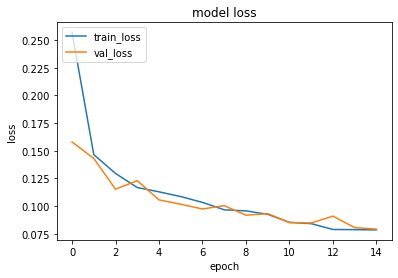

In [80]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [126]:
#reminder, 0 is TRUE and 1 is FAKE
def normalizePredictions(predictions):
    for x in range(0,len(predictions)):
        if predictions[x] <= 0.6:
            predictions[x] = 0.
        else:
            predictions[x] = 1
    return predictions


print("Generate predictions for the test set")
results = model.evaluate(testSet_text, testSet_label, batch_size=64)
print("test loss, test acc:", results)

predictions = model.predict(testSet_text)
predictions = normalizePredictions(predictions)


for n in range(0,50):
    print("Expected value: ",testSet_label[n]," Received value: ",predictions[n])
    

Generate predictions for the test set
79/79 [==============================] - 0s 2ms/step - loss: 0.0930 - accuracy: 0.9766
test loss, test acc: [0.09302478283643723, 0.9765999913215637]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value

##### 1.4 Taking care of the Dataset unbalance 

In [115]:
modelW= Sequential()
modelW.add(LSTM(100)) 
modelW.add(Dropout(0.3)) 
modelW.add(Dense(1,activation='sigmoid'))

modelW.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/15
311/311 [==============================] - 3s 5ms/step - loss: 0.3027 - accuracy: 0.9101 - val_loss: 0.1535 - val_accuracy: 0.9477
Epoch 2/15
311/311 [==============================] - 1s 4ms/step - loss: 0.1764 - accuracy: 0.9494 - val_loss: 0.1301 - val_accuracy: 0.9566
Epoch 3/15
311/311 [==============================] - 1s 3ms/step - loss: 0.1547 - accuracy: 0.9575 - val_loss: 0.1239 - val_accuracy: 0.9554
Epoch 4/15
311/311 [==============================] - 1s 4ms/step - loss: 0.1463 - accuracy: 0.9585 - val_loss: 0.1075 - val_accuracy: 0.9627
Epoch 5/15
311/311 [==============================] - 1s 4ms/step - loss: 0.1342 - accuracy: 0.9632 - val_loss: 0.1023 - val_accuracy: 0.9647
Epoch 6/15
311/311 [==============================] - 1s 4ms/step - loss: 0.1298 - accuracy: 0.9622 - val_loss: 0.0978 - val_accuracy: 0.9681
Epoch 7/15
311/311 [==============================] - 1s 4ms/step - loss: 0.1220 - accuracy: 0.9653 - val_loss: 0.0947 - val_accuracy: 0.9690
Epoch 

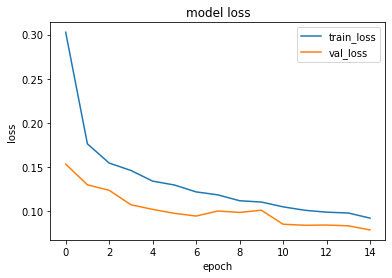

In [116]:
class_weights={0: 1, 1: 1.5}
whistory = modelW.fit(X_train,y_train,validation_data=(X_test,y_test), class_weight=class_weights, epochs=15,batch_size=64)
plt.plot(whistory.history['loss'])
plt.plot(whistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [127]:
print("Generate predictions for the test set")
results = modelW.evaluate(testSet_text, testSet_label, batch_size=64)
print("test loss, test acc:", results)

predictions = modelW.predict(testSet_text)
predictions = normalizePredictions(predictions)


for n in range(0,50):
    print("Expected value: ",testSet_label[n]," Received value: ",predictions[n])

Generate predictions for the test set
79/79 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9732
test loss, test acc: [0.07814265042543411, 0.9732000231742859]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value

#### 1.5 Experimenting with bidirectional LSTM 

In [69]:
from keras.layers import Bidirectional 

In [244]:
modelB= Sequential()
modelB.add(Bidirectional(LSTM(100))) 
modelB.add(Dropout(0.45)) 
modelB.add(Dense(1,activation='sigmoid'))

Epoch 1/30
311/311 [==============================] - 5s 7ms/step - loss: 0.2965 - accuracy: 0.9129 - val_loss: 0.1498 - val_accuracy: 0.9501
Epoch 2/30
311/311 [==============================] - 1s 5ms/step - loss: 0.1815 - accuracy: 0.9477 - val_loss: 0.1247 - val_accuracy: 0.9574
Epoch 3/30
311/311 [==============================] - 1s 4ms/step - loss: 0.1595 - accuracy: 0.9557 - val_loss: 0.1302 - val_accuracy: 0.9558
Epoch 4/30
311/311 [==============================] - 1s 5ms/step - loss: 0.1440 - accuracy: 0.9609 - val_loss: 0.1096 - val_accuracy: 0.9625
Epoch 5/30
311/311 [==============================] - 1s 5ms/step - loss: 0.1369 - accuracy: 0.9609 - val_loss: 0.1107 - val_accuracy: 0.9640
Epoch 6/30
311/311 [==============================] - 1s 5ms/step - loss: 0.1320 - accuracy: 0.9619 - val_loss: 0.1081 - val_accuracy: 0.9618
Epoch 7/30
311/311 [==============================] - 1s 5ms/step - loss: 0.1273 - accuracy: 0.9639 - val_loss: 0.1082 - val_accuracy: 0.9632
Epoch 

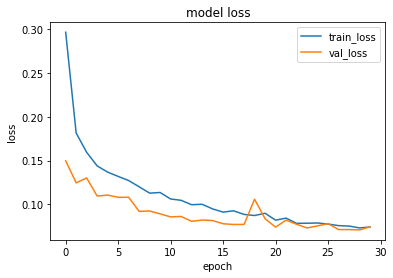

In [245]:
modelB.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
class_weights={0: 1, 1: 1.5}
whistory = modelB.fit(X_train,y_train,validation_data=(X_test,y_test), class_weight=class_weights, epochs=30,batch_size=64)
plt.plot(whistory.history['loss'])
plt.plot(whistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [246]:
print("Generate predictions for the test set")
results = modelB.evaluate(testSet_text, testSet_label, batch_size=64)
print("test loss, test acc:", results)

predictions = modelB.predict(testSet_text)
predictions = normalizePredictions(predictions)


for n in range(0,50):
    print("Expected value: ",testSet_label[n]," Received value: ",predictions[n])

Generate predictions for the test set
79/79 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.9768
test loss, test acc: [0.06837322562932968, 0.9768000245094299]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  0  Received value:  [0.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value:  1  Received value:  [1.]
Expected value

#### Section 2: Analysis 

The model chosen for the task of classifying the fake news and the real news was the LSTM.  
The Long Short-Term Memory model has some useful features such as elimination of unused information and memorizing the sequence of the information which makes the LSTM a powerful tool for performing text classification.   

Another motivation that lead to pick the LSTM model is the paper:   
[1][An LSTM Approach to Short Text Sentiment Classification with Word Embeddings](https://aclanthology.org/O18-1021) (Wang et al., ROCLING 2018)  
This paper states that comparing: Naïve Bayes (NB), Extreme Learning Machine (ELM), and Long Short-Term Memory (LSTM), the LSTM is the model that performs better in most tasks of text classification.

In the model used for this assignment an average 96% accuracy on the validation and 96.5% on the test set while using the unbalanced dataset (having more real news than fake ones) and a balanced test-set, was achieved.  
Using the same model as before, but taking into consideration the dataset unbalance applying the class weight which gives more importance to the miss-classified samples if they where part of the class with less samples (the fake news in our case), using this method an average 97.4% accuracy was achieved on the validation and with an average 97.6% on the test set while using, as before, the unbalanced dataset and a balanced test-set.  

Some experiments have been tried with a bidirectional LSTM, which in our case give slightly better results in the validation, than the standard LSTM, but at the cost of double the epochs which is non-ideal.

Some of the runs with different hyperparameter:                                                  
|                      |LSTM units|Dropout rate|Dense units|Epochs| loss | accuracy | val_loss | val_accuracy | test loss | test accuracy |
|----------------------|----------|------------|-----------|------|------|----------|----------|--------------|-----------|---------------|
|Without class weight  |90        |0.3         |1          |15    |0.0787|97.12%    |0.0806    |97.27%        |0.0930     |97.36%         | 
|Without class weight  |70        |0.4         |1          |15    |0.0946|96.64%    |0.0973    |96.69%        |0.0664     |97.10%         | 
|Without class weight  |70        |0.3         |1          |15    |0.0898|96.88%    |0.0902    |96.85%        |0.0961     |96.78%         |
|                      |          |            |           |      |      |          |          |              |           |               |
|With class weight     |100       |0.3         |1          |15    |0.0924|97.37%    |0.0790    |97.30%        |0.0781     |97.62%         | 
|With class weight     |70        |0.4         |1          |15    |0.0391|97.77%    |0.0634    |97.11%        |0.0957     |97.34%         | 
|With class weight     |70        |0.3         |1          |15    |0.1005|97.08%    |0.0904    |96.78%        |0.0895     |97.03%         |
|                      |          |            |           |      |      |          |          |              |           |               |
|Bidirectional         |          |            |           |      |      |          |          |              |           |               |
|With class weight     |100       |0.45        |1          |30    |0.0814|97.50%    |0.0730    |97.54%        |0.0683     |97.68%         |
|With class weight     |100       |0.35        |1          |20    |0.1085|96.86%    |0.0860    |97.18%        |0.0753     |97.22%         |
|With class weight     |100       |0.4         |1          |20    |0.0839|97.48%    |0.0766    |97.30%        |0.0805     |97.23%         |



#### Section 3: Conclusions

The choice of the LSTM model, trained in this assignment, has given quite satisfying results considering that even in the case where we ignore the unbalance we get quite an high accuracy, well over 90%; the accuracy gets even higher when we take into account the unbalance between the fake news and real news and "punish" the model more if the misclassification happens in the smaller class.    
On the other hand if we want to build a more "trustworthy" model we would probably want to compare the news we are analyzing to news that can be found on authoritative sources to cross validate them.   
The implementation of such mechanism would help avoiding cases where the prediction is wrong just due to the subject of the prediction or the structure of the text analyzed. This could be a concern if these text formulations and subjects, are only present or present in a way higher number of examples, in the fake news portion of the dataset.  
Overall the LSTM seems to be a good pick for text classification.      
